In [1]:
import sys
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from tqdm import tqdm
from matplotlib import pyplot as plt

from src.visualization import set_themes
from src.preprocessing import construct_features_meta
from src.preprocessing.data_loader import load_data
from src.sampler import SimpleSampler
from src.losses.bayesian_personalized_ranking import BayesianPersonalizedRankingLoss
from src.models.matrix_factorization import MatrixFactorization
from src.baremetal import gather_dense

from collections import defaultdict

set_themes()
tf.config.list_logical_devices()

2026-01-11 10:19:30.392986: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
failed to send, dropping 5 traces to intake at http://localhost:8126/v0.5/traces after 3 retries
/home/hafidh_rendyanto/documents/peppermint-matrix/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


2026-01-11 10:19:33.801494: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1768126773.803199 1908748 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19166 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Load Datasets

In [2]:
train_user_interaction = load_data("dataset/yelp2018/train.txt")
train_features_meta = construct_features_meta(train_user_interaction)
train_user_interaction

,user_id,item_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
1237254,31667,22984
1237255,31667,12943
1237256,31667,29149
1237257,31667,4927


In [3]:
test_user_interaction = load_data("dataset/yelp2018/test.txt")
test_features_meta = construct_features_meta(test_user_interaction)
test_user_interaction

,user_id,item_id
0,0,795
1,0,694
2,0,1531
3,0,14517
4,0,8784
...,...,...
324142,31667,33811
324143,31667,10482
324144,31667,9585
324145,31667,36460


In [4]:
user_items = train_user_interaction.groupby("user_id")["item_id"].apply(set).to_dict()
item_users = train_user_interaction.groupby("item_id")["user_id"].apply(set).to_dict()

In [5]:
# train dataset features meta without vocabulary
{feature_name: {k: v for k, v in meta.items() if k not in ["vocabulary"]} for feature_name, meta in train_features_meta.items()}

{'user_id': {'dtype': 'int64', 'unique_count': 31668},
 'item_id': {'dtype': 'int64', 'unique_count': 38048}}

In [6]:
# test dataset features meta without vocabulary
{feature_name: {k: v for k, v in meta.items() if k not in ["vocabulary"]} for feature_name, meta in test_features_meta.items()}

{'user_id': {'dtype': 'int64', 'unique_count': 31668},
 'item_id': {'dtype': 'int64', 'unique_count': 36073}}

In [7]:
train_interaction_matrix = tf.sparse.SparseTensor(
    indices=train_user_interaction[["user_id", "item_id"]].values,
    values=tf.ones(shape=(len(train_user_interaction),), dtype=tf.int32),
    dense_shape=(train_features_meta['user_id']['unique_count'], train_features_meta['item_id']['unique_count'])
)
train_interaction_matrix

SparseTensor(indices=tf.Tensor(
[[    0     0]
 [    0     1]
 [    0     2]
 ...
 [31667 29149]
 [31667  4927]
 [31667 31751]], shape=(1237259, 2), dtype=int64), values=tf.Tensor([1 1 1 ... 1 1 1], shape=(1237259,), dtype=int32), dense_shape=tf.Tensor([31668 38048], shape=(2,), dtype=int64))

In [8]:
test_interaction_matrix = tf.sparse.SparseTensor(
    indices=test_user_interaction[["user_id", "item_id"]].values,
    values=tf.ones(shape=(len(test_user_interaction),), dtype=tf.int32),
    dense_shape=(train_features_meta['user_id']['unique_count'], train_features_meta['item_id']['unique_count'])
)
test_interaction_matrix

SparseTensor(indices=tf.Tensor(
[[    0   795]
 [    0   694]
 [    0  1531]
 ...
 [31667  9585]
 [31667 36460]
 [31667 26812]], shape=(324147, 2), dtype=int64), values=tf.Tensor([1 1 1 ... 1 1 1], shape=(324147,), dtype=int32), dense_shape=tf.Tensor([31668 38048], shape=(2,), dtype=int64))

# Model Definition

In [17]:
sampler = SimpleSampler(item_set=train_features_meta["item_id"]["vocabulary"], user_items=user_items)

model = MatrixFactorization(
    train_features_meta, 
    embedding_dimension_count=64,
    l2_regularization=1e-6
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss_functions=[
        BayesianPersonalizedRankingLoss()
    ],
    sampler=sampler
)

# Model Training

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    {
        "user_id": train_user_interaction["user_id"].values,
        "item_id": train_user_interaction["item_id"].values
    }
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    {
        "user_id": test_user_interaction["user_id"].values,
        "item_id": test_user_interaction["item_id"].values
    }
)
print(f"Training Dataset: {len(train_dataset)}")
print(f"Test Dataset: {len(test_dataset)}")

Training Dataset: 1237259
Test Dataset: 324147


In [19]:
model.fit(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    nepochs=20,
    shuffle=True,
    batch_size=16384
)

[20/20]: 100%|██████████████████████████████████████████████| 31668/31668 [00:20<00:00, 1550.46it/s]


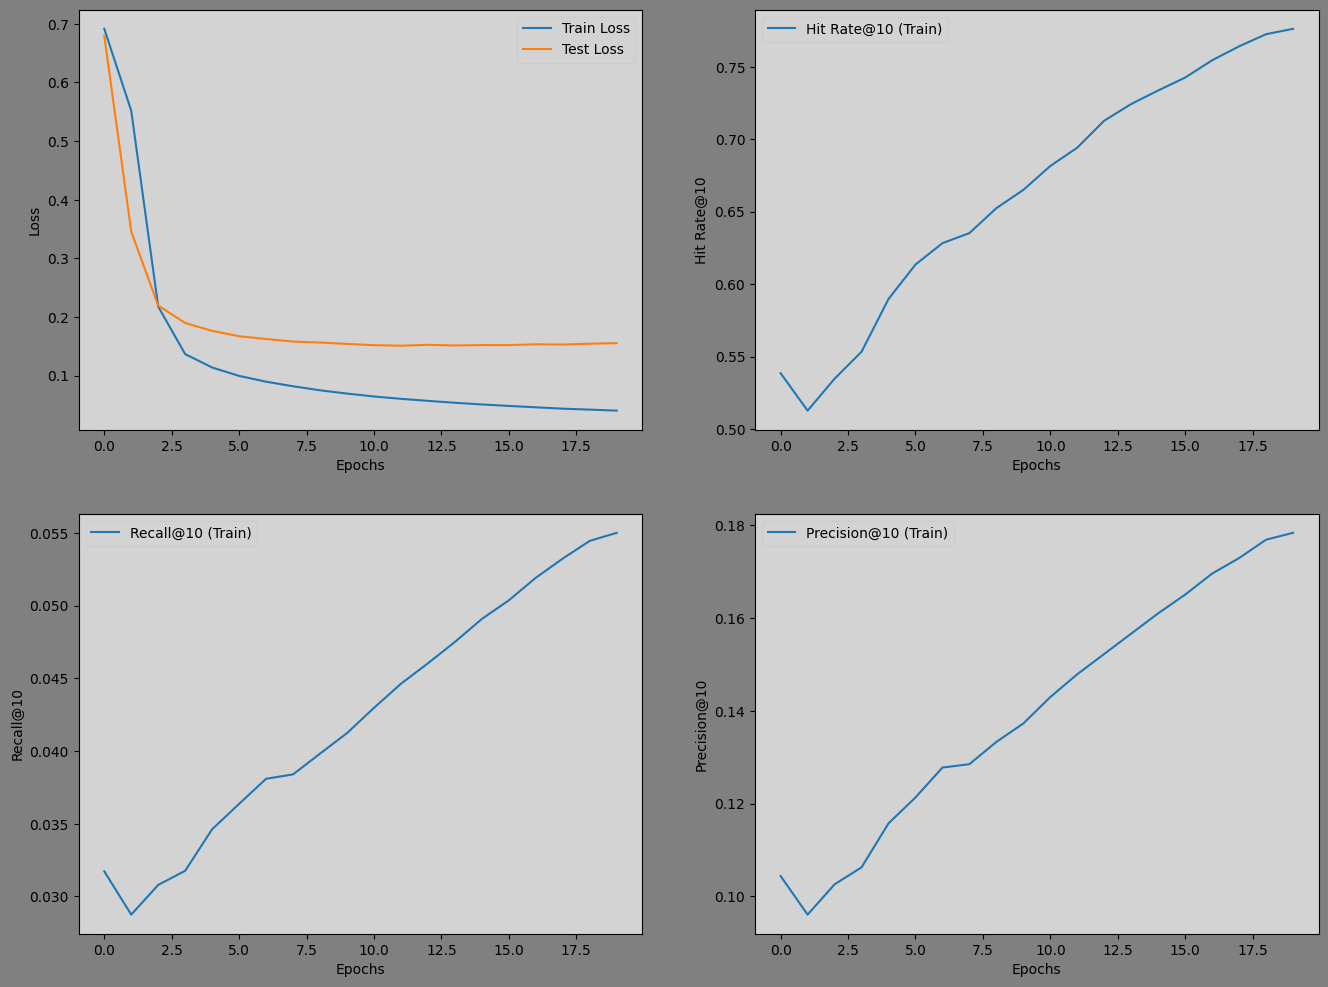

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries, 3 additional messages skipped


In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Loss History
ax[0, 0].plot(model.train_loss_history, label="Train Loss")
ax[0, 0].plot(model.test_loss_history, label="Test Loss")
ax[0, 0].set_xlabel("Epochs")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()

# Hit Rate History
ax[0, 1].plot(model.train_hit_rate_history, label="Hit Rate@10 (Train)")
ax[0, 1].set_xlabel("Epochs")
ax[0, 1].set_ylabel("Hit Rate@10")
ax[0, 1].legend()

# Recall History
ax[1, 0].plot(model.train_recall_history, label="Recall@10 (Train)")
ax[1, 0].set_xlabel("Epochs")
ax[1, 0].set_ylabel("Recall@10")
ax[1, 0].legend()

# Precision History
ax[1, 1].plot(model.train_precision_history, label="Precision@10 (Train)")
ax[1, 1].set_xlabel("Epochs")
ax[1, 1].set_ylabel("Precision@10")
ax[1, 1].legend()

plt.show()

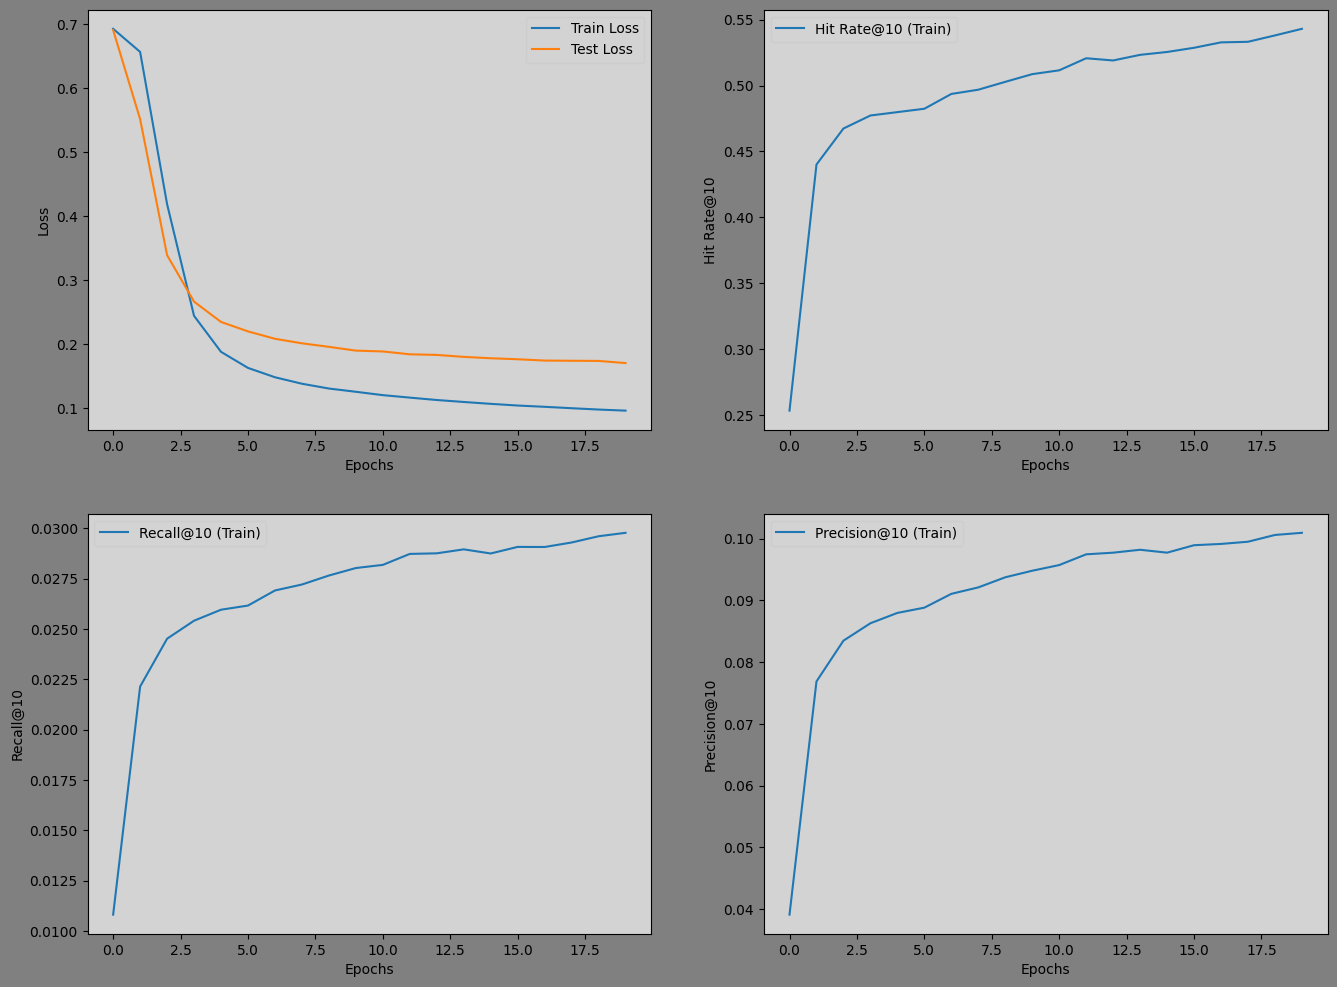

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries, 2 additional messages skipped


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Loss History
ax[0, 0].plot(model.train_loss_history, label="Train Loss")
ax[0, 0].plot(model.test_loss_history, label="Test Loss")
ax[0, 0].set_xlabel("Epochs")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()

# Hit Rate History
ax[0, 1].plot(model.train_hit_rate_history, label="Hit Rate@10 (Train)")
ax[0, 1].set_xlabel("Epochs")
ax[0, 1].set_ylabel("Hit Rate@10")
ax[0, 1].legend()

# Recall History
ax[1, 0].plot(model.train_recall_history, label="Recall@10 (Train)")
ax[1, 0].set_xlabel("Epochs")
ax[1, 0].set_ylabel("Recall@10")
ax[1, 0].legend()

# Precision History
ax[1, 1].plot(model.train_precision_history, label="Precision@10 (Train)")
ax[1, 1].set_xlabel("Epochs")
ax[1, 1].set_ylabel("Precision@10")
ax[1, 1].legend()

plt.show()

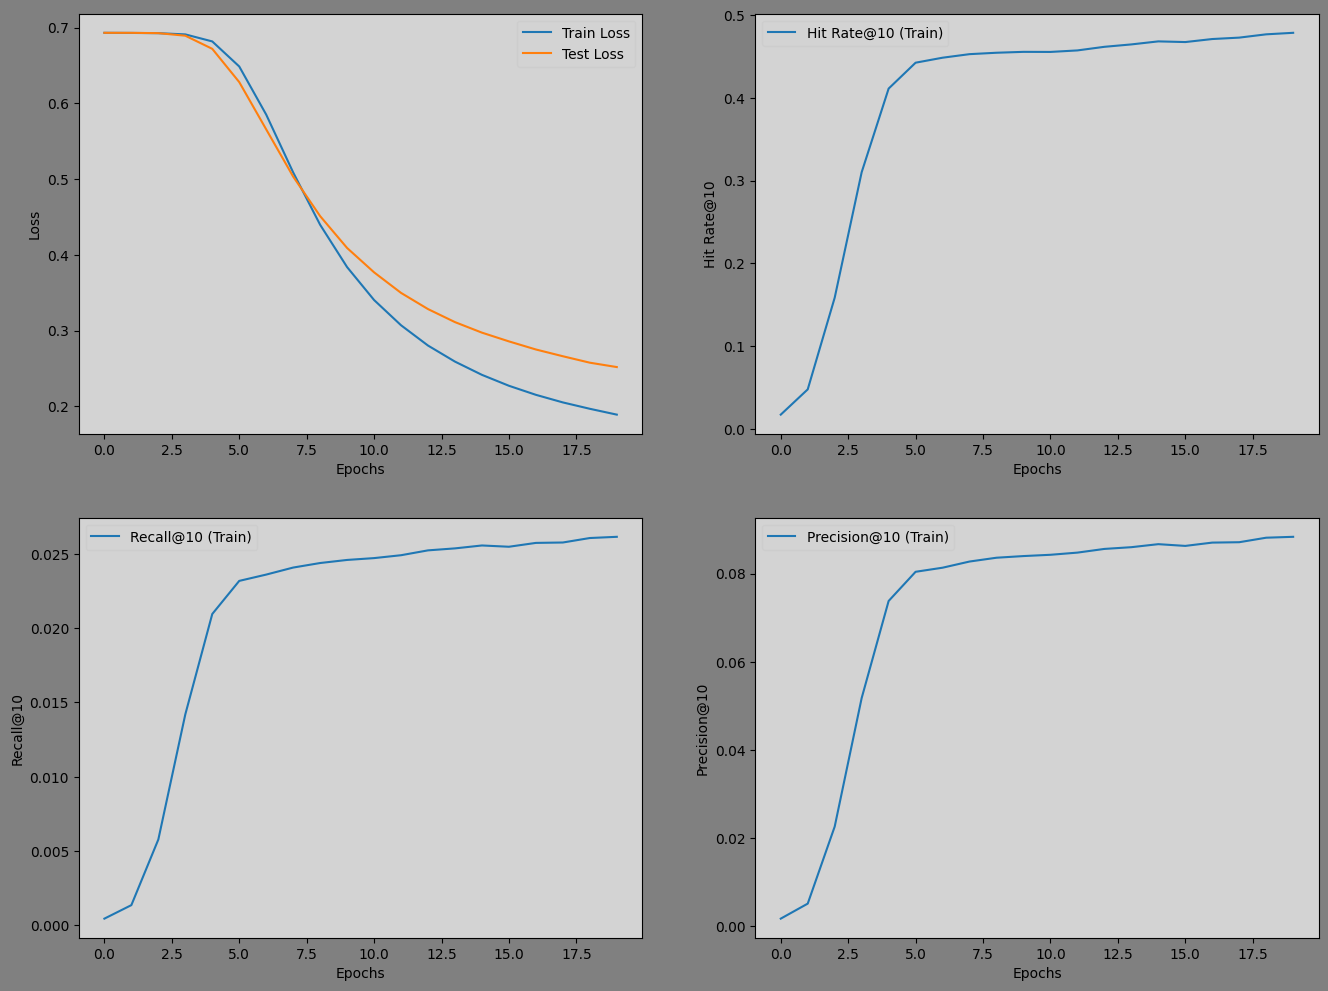

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries, 6 additional messages skipped


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Loss History
ax[0, 0].plot(model.train_loss_history, label="Train Loss")
ax[0, 0].plot(model.test_loss_history, label="Test Loss")
ax[0, 0].set_xlabel("Epochs")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()

# Hit Rate History
ax[0, 1].plot(model.train_hit_rate_history, label="Hit Rate@10 (Train)")
ax[0, 1].set_xlabel("Epochs")
ax[0, 1].set_ylabel("Hit Rate@10")
ax[0, 1].legend()

# Recall History
ax[1, 0].plot(model.train_recall_history, label="Recall@10 (Train)")
ax[1, 0].set_xlabel("Epochs")
ax[1, 0].set_ylabel("Recall@10")
ax[1, 0].legend()

# Precision History
ax[1, 1].plot(model.train_precision_history, label="Precision@10 (Train)")
ax[1, 1].set_xlabel("Epochs")
ax[1, 1].set_ylabel("Precision@10")
ax[1, 1].legend()

plt.show()

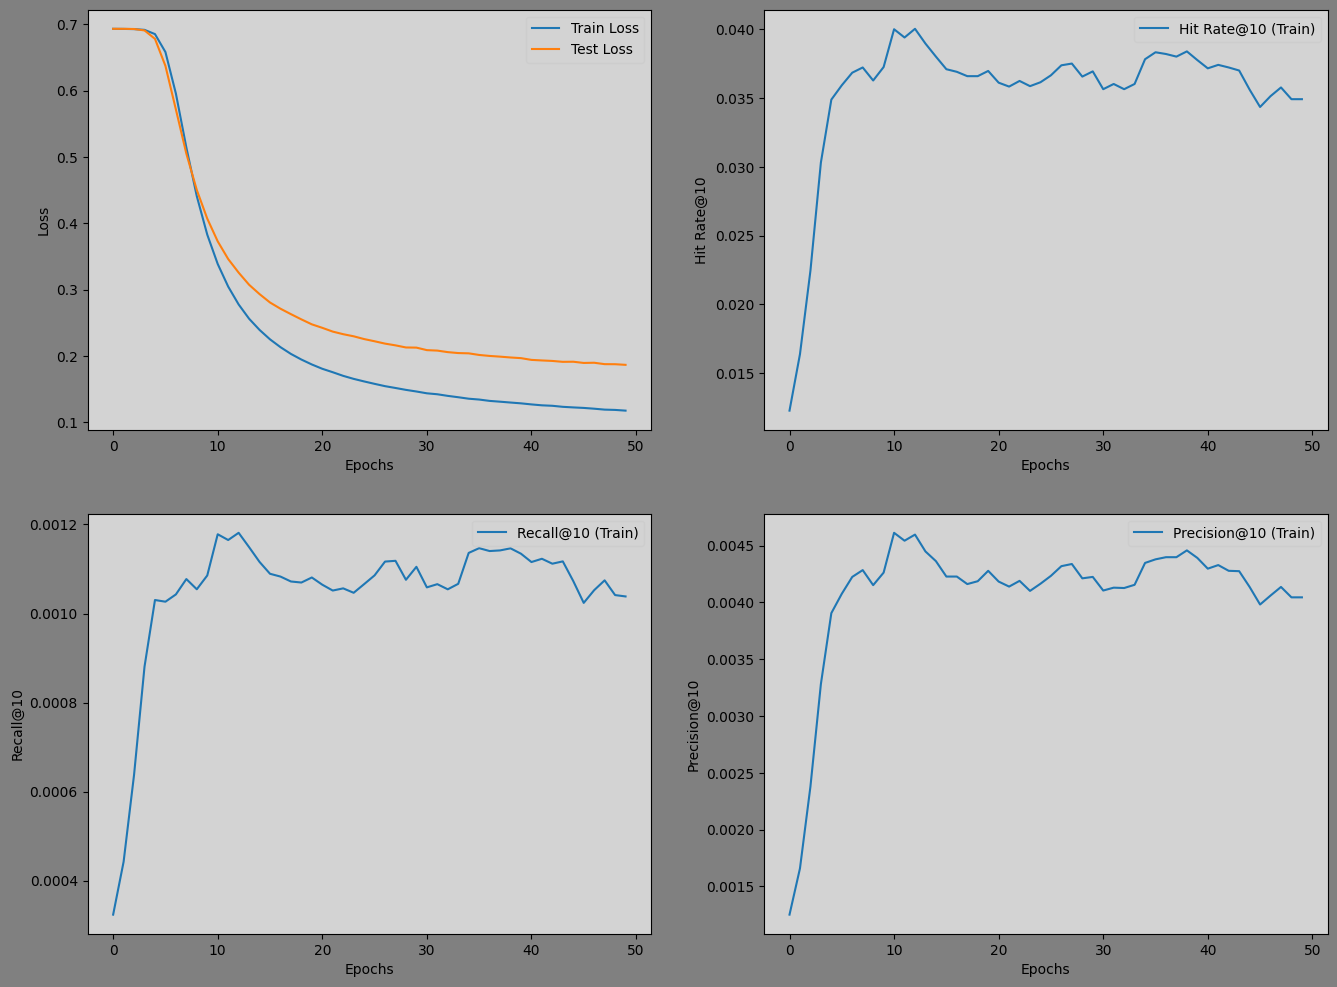

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries, 8 additional messages skipped


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# Loss History
ax[0, 0].plot(model.train_loss_history, label="Train Loss")
ax[0, 0].plot(model.test_loss_history, label="Test Loss")
ax[0, 0].set_xlabel("Epochs")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()

# Hit Rate History
ax[0, 1].plot(model.train_hit_rate_history, label="Hit Rate@10 (Train)")
ax[0, 1].set_xlabel("Epochs")
ax[0, 1].set_ylabel("Hit Rate@10")
ax[0, 1].legend()

# Recall History
ax[1, 0].plot(model.train_recall_history, label="Recall@10 (Train)")
ax[1, 0].set_xlabel("Epochs")
ax[1, 0].set_ylabel("Recall@10")
ax[1, 0].legend()

# Precision History
ax[1, 1].plot(model.train_precision_history, label="Precision@10 (Train)")
ax[1, 1].set_xlabel("Epochs")
ax[1, 1].set_ylabel("Precision@10")
ax[1, 1].legend()

plt.show()

In [17]:
ax

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: xlabel='Epochs', ylabel='Loss'>]], dtype=object)

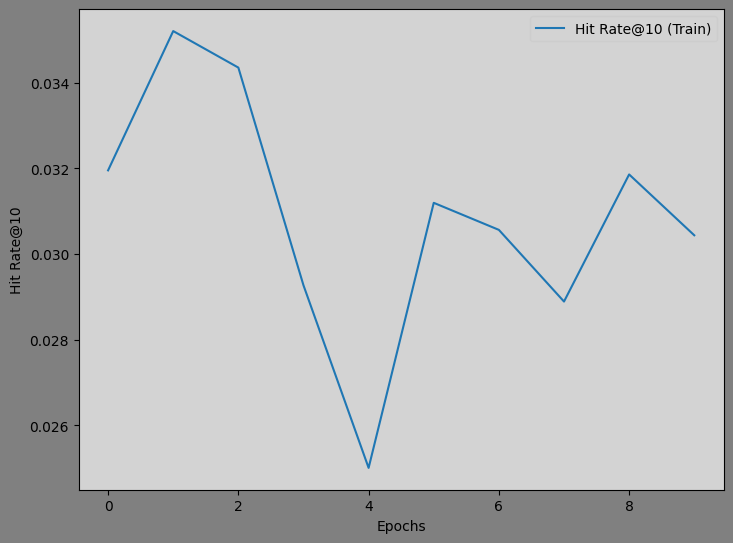

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries, 2 additional messages skipped


In [ ]:
plt.plot(model.train_hit_rate_history, label="Hit Rate@10 (Train)")
plt.xlabel("Epochs")
plt.ylabel("Hit Rate@10")
plt.legend()
plt.show()

In [15]:
train_interaction_history_matrix = model.construct_interaction_matrix(model.train_interaction_history)
train_interaction_history_matrix

SparseTensor(indices=tf.Tensor(
[[    1     1]
 [    1     2]
 [    1     3]
 ...
 [31668 31217]
 [31668 31752]
 [31668 33574]], shape=(1237259, 2), dtype=int64), values=tf.Tensor([1 1 1 ... 1 1 1], shape=(1237259,), dtype=int32), dense_shape=tf.Tensor([31669 38049], shape=(2,), dtype=int64))

In [16]:
gather_dense(train_interaction_history_matrix, row_indices=tf.constant([1, 2, 3], dtype=tf.int64))

<tf.Tensor: shape=(3, 38049), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(3, 38049), dtype=int32)>

In [ ]:
user_candidates = tf.range(model.user_lookup_layer.vocabulary_size(), dtype=tf.int64)
item_candidates = tf.range(model.item_lookup_layer.vocabulary_size(), dtype=tf.int64)
user_dataset = tf.data.Dataset.from_tensor_slices(user_candidates)
user_dataset = user_dataset.batch(4)

k = 10
for step, user_batch in enumerate(user_dataset):
    user_embedding = model.user_embedding(user_batch)
    candidate_item_embedding = model.item_embedding(item_candidates)
    predicted_scores = tf.matmul(user_embedding, tf.transpose(candidate_item_embedding))
    predicted_rankings = tf.argsort(tf.argsort(predicted_scores, direction='DESCENDING', axis=-1), axis=-1) + 1 # argsort twice gets you rankings of each item

    ground_truth_interaction_matrix = gather_dense(train_interaction_history_matrix, user_batch)

    true_positives = tf.cast((predicted_rankings <= k) * ground_truth_interaction_matrix, tf.int32)
    true_positive_count = tf.reduce_sum(true_positives, axis=-1) # true_positives per user
    actual_positive_count = tf.reduce_sum(ground_truth_interaction_matrix, axis=-1) # actual positives per user
    
    break

true_positives

<tf.Tensor: shape=(4, 38049), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(4, 38049), dtype=int32)>

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries


In [26]:
# recall@k
tf.math.divide_no_nan(true_positive_count, actual_positive_count)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.        , 0.        , 0.        , 0.07352941])>

In [ ]:
# precision@k
tf.math.divide_no_nan(true_positive_count, k)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0. , 0. , 0. , 0.5])>

In [ ]:
# hit rate@k
tf.reduce_mean(tf.cast(true_positive_count > 0, tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries, 3 additional messages skipped


In [13]:
# user_set = tf.constant(random.sample(train_features_meta["user_id"]["vocabulary"], k=3), dtype=tf.int64)
user_set = tf.constant(train_features_meta["user_id"]["vocabulary"][:1000], dtype=tf.int64)
item_set = tf.constant(train_features_meta["item_id"]["vocabulary"], dtype=tf.int64)

user_set

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 

In [73]:
user_embedding = model.user_embedding(user_set)
candidate_item_embedding = model.item_embedding(item_set)
predicted_scores = tf.matmul(user_embedding, tf.transpose(candidate_item_embedding))
predicted_scores

<tf.Tensor: shape=(1000, 38048), dtype=float32, numpy=
array([[ 6.0876784 ,  2.1574876 ,  4.076797  , ..., -0.342301  ,
        -0.67550695, -0.14702928],
       [ 1.86958   ,  2.6382515 ,  3.816721  , ...,  0.43572617,
         0.7770732 , -0.04287499],
       [-2.2921698 ,  5.43791   ,  6.352863  , ...,  0.6130545 ,
         1.193526  ,  0.9526242 ],
       ...,
       [ 8.126422  ,  0.31043842,  1.348511  , ..., -0.5493018 ,
        -0.52564186, -0.81566286],
       [ 5.1311755 ,  0.61092746,  0.3284857 , ..., -0.92135984,
         0.240304  , -1.2962191 ],
       [ 8.145863  ,  0.46666571,  1.21727   , ..., -0.5792842 ,
        -0.13437335, -1.012572  ]], shape=(1000, 38048), dtype=float32)>

In [74]:
current_train_interaction_matrix = gather_dense(train_interaction_matrix, user_set)
current_train_interaction_matrix

<tf.Tensor: shape=(1000, 38048), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1000, 38048), dtype=int32)>

In [75]:
current_test_interaction_matrix = gather_dense(test_interaction_matrix, user_set)
current_test_interaction_matrix

<tf.Tensor: shape=(1000, 38048), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1000, 38048), dtype=int32)>

In [76]:
predicted_rankings = tf.argsort(tf.argsort(predicted_scores, direction='DESCENDING', axis=-1), axis=-1) + 1 # argsort twice gets you rankings of each item
predicted_rankings

<tf.Tensor: shape=(1000, 38048), dtype=int32, numpy=
array([[    4,  2962,   297, ..., 22275, 23455, 21117],
       [ 6002,  3684,  2427, ..., 15920, 12623, 20556],
       [35084,   957,   653, ..., 13099, 10454, 11350],
       ...,
       [   12, 15257,  9653, ..., 20818, 20672, 22321],
       [  544, 10377, 13689, ..., 28241, 14818, 30965],
       [   37, 11841, 10146, ..., 18284, 14974, 21720]],
      shape=(1000, 38048), dtype=int32)>

In [77]:
current_train_interaction_matrix

<tf.Tensor: shape=(1000, 38048), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1000, 38048), dtype=int32)>

In [78]:
k = 10
true_positives = tf.cast((predicted_rankings <= k) * current_train_interaction_matrix, tf.int32)
true_positives

<tf.Tensor: shape=(1000, 38048), dtype=int32, numpy=
array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1000, 38048), dtype=int32)>

In [79]:
true_positive_count = tf.reduce_sum(true_positives, axis=-1) # true_positives per user
true_positive_count

<tf.Tensor: shape=(1000,), dtype=int32, numpy=
array([2, 7, 5, 1, 1, 1, 1, 2, 1, 3, 1, 1, 5, 1, 0, 2, 2, 2, 3, 4, 0, 1,
       2, 4, 2, 2, 1, 2, 3, 2, 0, 1, 4, 1, 1, 0, 1, 6, 1, 1, 0, 0, 0, 6,
       0, 2, 2, 2, 1, 0, 0, 0, 0, 3, 0, 3, 1, 3, 2, 2, 0, 2, 1, 1, 3, 1,
       0, 4, 2, 1, 0, 0, 4, 1, 0, 0, 0, 0, 0, 2, 6, 1, 0, 0, 3, 2, 1, 1,
       2, 0, 1, 0, 3, 1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1,
       2, 1, 0, 4, 2, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 1,
       3, 2, 2, 0, 3, 0, 1, 5, 4, 1, 0, 1, 3, 2, 0, 0, 6, 3, 0, 1, 0, 4,
       1, 0, 1, 2, 3, 1, 2, 0, 0, 0, 3, 0, 0, 1, 0, 3, 1, 2, 0, 1, 0, 1,
       0, 0, 0, 1, 3, 0, 4, 0, 0, 4, 0, 3, 1, 2, 1, 1, 0, 0, 2, 0, 2, 0,
       3, 0, 4, 3, 1, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 3, 3, 0, 0, 1, 1, 1,
       0, 2, 2, 2, 7, 1, 2, 1, 0, 1, 0, 1, 0, 0, 3, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 0, 2, 0, 0, 2, 0, 3, 0, 0,
       0, 1, 0, 2, 2, 0, 2, 0, 3, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0,
    

In [80]:
actual_positive_count = tf.reduce_sum(current_train_interaction_matrix, axis=-1) # actual positives per user
actual_positive_count

<tf.Tensor: shape=(1000,), dtype=int32, numpy=
array([  18,  536,   68,   16,   24,   18,   88,   16,   29,   24,   22,
         22,   33,   56,   45,   20,   48,   49,   53,  127,   24,   72,
         29,   23,   38,   21,   28,   53,  189,   58,  113,   45,   35,
         16,   22,   21,   16, 1032,   25,   20,   19,   21,   52,  195,
         16,   37,   76,   55,   16,   20,   17,   40,   31,   24,   16,
        108,   60,   20,   62,   33,   23,   55,   23,   42,   36,   57,
         72,   34,   19,   28,   16,   56,   40,   42,   33,   21,   28,
         18,   17,   46,  301,   17,   62,   17,  112,   52,  188,   49,
         53,   17,   25,   16,   53,   26,  113,   39,   17,  183,   62,
         18,   69,   26,   36,   16,   37,   41,   28,   16,   28,  211,
        184,   28,   18,   31,  171,   34,   30,   16,   17,   40,   97,
         16,   18,   78,   63,   21,   57,   43,   21,   20,   69,   35,
         49,   42,   59,   68,  176,   22,   16,   36,   33,   17,   22,
    

In [81]:
# recall@k
true_positive_count / actual_positive_count

<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([0.11111111, 0.0130597 , 0.07352941, 0.0625    , 0.04166667,
       0.05555556, 0.01136364, 0.125     , 0.03448276, 0.125     ,
       0.04545455, 0.04545455, 0.15151515, 0.01785714, 0.        ,
       0.1       , 0.04166667, 0.04081633, 0.05660377, 0.03149606,
       0.        , 0.01388889, 0.06896552, 0.17391304, 0.05263158,
       0.0952381 , 0.03571429, 0.03773585, 0.01587302, 0.03448276,
       0.        , 0.02222222, 0.11428571, 0.0625    , 0.04545455,
       0.        , 0.0625    , 0.00581395, 0.04      , 0.05      ,
       0.        , 0.        , 0.        , 0.03076923, 0.        ,
       0.05405405, 0.02631579, 0.03636364, 0.0625    , 0.        ,
       0.        , 0.        , 0.        , 0.125     , 0.        ,
       0.02777778, 0.01666667, 0.15      , 0.03225806, 0.06060606,
       0.        , 0.03636364, 0.04347826, 0.02380952, 0.08333333,
       0.01754386, 0.        , 0.11764706, 0.10526316, 0.03571429,
       0.    

In [82]:
# precision@k
true_positive_count / k

<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([0.2, 0.7, 0.5, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.3, 0.1, 0.1, 0.5,
       0.1, 0. , 0.2, 0.2, 0.2, 0.3, 0.4, 0. , 0.1, 0.2, 0.4, 0.2, 0.2,
       0.1, 0.2, 0.3, 0.2, 0. , 0.1, 0.4, 0.1, 0.1, 0. , 0.1, 0.6, 0.1,
       0.1, 0. , 0. , 0. , 0.6, 0. , 0.2, 0.2, 0.2, 0.1, 0. , 0. , 0. ,
       0. , 0.3, 0. , 0.3, 0.1, 0.3, 0.2, 0.2, 0. , 0.2, 0.1, 0.1, 0.3,
       0.1, 0. , 0.4, 0.2, 0.1, 0. , 0. , 0.4, 0.1, 0. , 0. , 0. , 0. ,
       0. , 0.2, 0.6, 0.1, 0. , 0. , 0.3, 0.2, 0.1, 0.1, 0.2, 0. , 0.1,
       0. , 0.3, 0.1, 0.2, 0.2, 0.1, 0. , 0.2, 0.1, 0. , 0. , 0.1, 0.1,
       0. , 0.2, 0. , 0.1, 0.1, 0.1, 0.2, 0.1, 0. , 0.4, 0.2, 0.1, 0. ,
       0.1, 0.1, 0. , 0.1, 0.1, 0.1, 0.2, 0. , 0.1, 0.1, 0.2, 0. , 0. ,
       0.1, 0.1, 0.3, 0.2, 0.2, 0. , 0.3, 0. , 0.1, 0.5, 0.4, 0.1, 0. ,
       0.1, 0.3, 0.2, 0. , 0. , 0.6, 0.3, 0. , 0.1, 0. , 0.4, 0.1, 0. ,
       0.1, 0.2, 0.3, 0.1, 0.2, 0. , 0. , 0. , 0.3, 0. , 0. , 0.1, 0. ,
       0.3, 0.1

In [83]:
# hit rate@k
tf.reduce_mean(tf.cast(true_positive_count > 0, tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.6129999756813049>

In [40]:
predicted_scores[:, :5]

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 4.3421607 ,  0.1691009 ,  0.7304248 ,  2.1951814 ,  3.068948  ],
       [ 3.308554  , -1.0128102 , -3.8649971 ,  0.19729936, -3.1450367 ],
       [-6.301557  ,  2.2997363 ,  1.4654694 , -2.7348366 , -1.5999881 ],
       [-4.088215  ,  1.8638742 ,  1.0919405 , -2.2237213 , -1.5178311 ]],
      dtype=float32)>

In [42]:
tf.argsort(tf.argsort(predicted_scores[:, :5], direction='DESCENDING', axis=-1), axis=-1) + 1

<tf.Tensor: shape=(4, 5), dtype=int32, numpy=
array([[1, 5, 4, 3, 2],
       [1, 3, 5, 2, 4],
       [5, 1, 2, 4, 3],
       [5, 1, 2, 4, 3]], dtype=int32)>

# Archive

In [20]:
nepochs = 1
loss_batch_history = []
loss_epoch_history = []
for epoch in range(nepochs):
    current_batch_losses = []
    with tqdm(total=len(train_user_interaction), ncols=100, desc=f"[{epoch+1}/{nepochs}]") as pbar:
        for step, training_batch in enumerate(train_dataset.batch(16384)):
            user_ids = training_batch["user_id"]
            item_ids = training_batch["item_id"]

            # random negative sample
            random_negatives = model.sampler.sample(user_ids)
            
            with tf.GradientTape() as tape:
                user_embedding = model.user_embedding(user_ids)
                item_embedding = model.item_embedding(item_ids)
                negative_embedding = model.item_embedding(random_negatives)

                positive_prediction = tf.reduce_sum(user_embedding * item_embedding, axis=-1)
                negative_prediction = tf.reduce_sum(user_embedding * negative_embedding, axis=-1)

                loss_value = tf.reduce_mean(-tf.math.log(tf.sigmoid(positive_prediction - negative_prediction)))

            # calculate gradient
            user_gradient, item_gradient = tape.gradient(loss_value, model.user_embedding_layer.trainable_variables + model.item_embedding_layer.trainable_variables)

            # back propagation
            model.optimizer.apply_gradients(zip([user_gradient, item_gradient], model.user_embedding_layer.trainable_variables + model.item_embedding_layer.trainable_variables))

            loss_batch_history.append(float(loss_value))
            current_batch_losses.append(float(loss_value))

            pbar.update(len(user_ids))
            pbar.set_postfix({"loss": float(loss_value)})
    loss_epoch_history.append(float(tf.reduce_mean(current_batch_losses)))

[1/1]: 100%|███████████████████████████████| 1237259/1237259 [00:02<00:00, 578737.65it/s, loss=0.11]


In [21]:
user_ids

<tf.Tensor: shape=(8459,), dtype=int64, numpy=array([31349, 31349, 31350, ..., 31667, 31667, 31667], shape=(8459,))>

In [22]:
item_ids

<tf.Tensor: shape=(8459,), dtype=int64, numpy=array([ 6836, 28068,   426, ..., 29149,  4927, 31751], shape=(8459,))>

In [90]:
tf.stack([user_ids, item_ids], axis=-1)

<tf.Tensor: shape=(8459, 2), dtype=int64, numpy=
array([[31349,  6836],
       [31349, 28068],
       [31350,   426],
       ...,
       [31667, 29149],
       [31667,  4927],
       [31667, 31751]], shape=(8459, 2))>

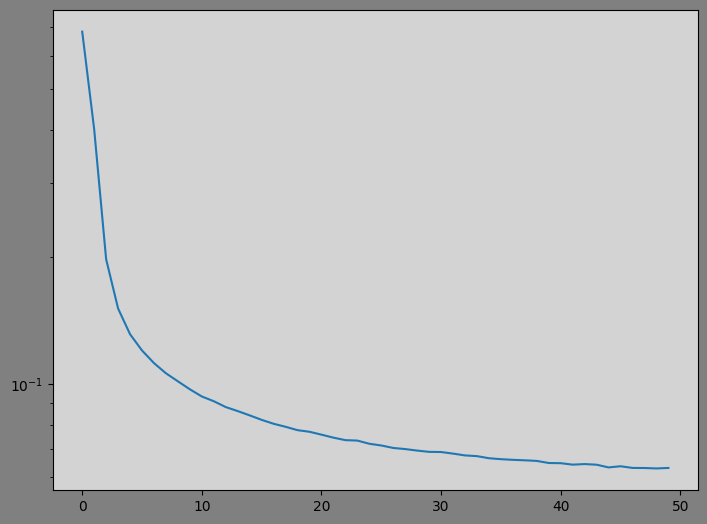

In [11]:
plt.plot(loss_epoch_history)
plt.yscale("log")
plt.show()

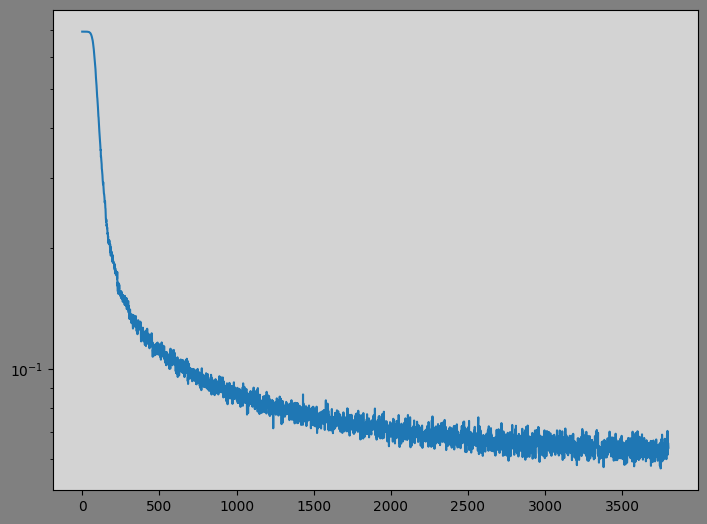

In [12]:
plt.plot(loss_batch_history)
plt.yscale("log")
plt.show()